In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import random
from sklearn.manifold import TSNE
import torch.optim as optim
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.manifold import TSNE

In [2]:
df_raw = pd.read_csv("magic04.csv", header=None)
#print(df_raw)

In [3]:
y = df_raw.iloc[:,-1]
x = df_raw.iloc[:,0:-1]
x = (x - x.min()) / (x.max() - x.min()) #normalized x

#Train Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=3)

y_train = pd.get_dummies(y_train)
df_train = pd.concat([x_train, y_train], axis =1)
df_train



,0,1,2,3,4,5,6,7,8,9,-1,1
2311,0.343330,0.189790,0.488941,0.153767,0.124759,0.349782,0.375302,0.617077,0.315689,0.652214,1,0
15099,0.092319,0.073548,0.184329,0.344357,0.255890,0.442684,0.640986,0.503116,0.164447,0.443803,0,1
12223,0.092069,0.082445,0.286783,0.314240,0.225959,0.485054,0.634467,0.500884,0.275167,0.110020,0,1
8988,0.083809,0.075099,0.250414,0.384930,0.297526,0.449505,0.629470,0.495574,0.041182,0.221062,0,1
10651,0.346529,0.172586,0.477380,0.186158,0.148170,0.350469,0.608245,0.609925,0.045933,0.577422,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6400,0.107346,0.035543,0.242815,0.486533,0.360498,0.453990,0.609863,0.542559,0.559680,0.351721,1,0
15288,0.061006,0.049978,0.167120,0.445392,0.311157,0.463794,0.572596,0.517849,0.247111,0.266802,0,1
11513,0.111099,0.056020,0.178415,0.465053,0.318714,0.494814,0.594160,0.559194,0.004378,0.324071,0,1
1688,0.284821,0.053277,0.068628,0.601091,0.436954,0.524177,0.697156,0.546155,0.449500,0.333166,1,0


In [4]:
# 1 greater than 4369 values than -1
# generate 4369 sample for -1

df_train_1 = df_train[df_train.iloc[:,-1]==1]
df_train_n1 = df_train[df_train.iloc[:,-2]==1]
print("df_train_1:", df_train_1.shape)
print("df_train_n1:", df_train_n1.shape)
#y_train.shape




df_train_1: (10771, 12)
df_train_n1: (5988, 12)


In [5]:

x = df_train_n1.iloc[:,:-2 ]
y = df_train_n1.iloc[:,-2: ]
print(y)

y = torch.Tensor(y.values)
x = torch.Tensor(x.values)

      -1   1
2311   1   0
6610   1   0
6493   1   0
2569   1   0
4563   1   0
...   ..  ..
6542   1   0
1447   1   0
6400   1   0
1688   1   0
5994   1   0

[5988 rows x 2 columns]


In [6]:
#Generate Data for minority class M

class VariationalAutoencoder(nn.Module):
    def __init__(self, num_features=5, num_dim=10):
        super(VariationalAutoencoder, self).__init__()
        
        self.num_features = num_features
        self.num_dim = num_dim
        
        self.encoder_layer_1 = nn.Linear(in_features=self.num_dim, out_features=5)
        self.encoder_layer_2 = nn.Linear(in_features=5, out_features=(self.num_features * 2))
        
        self.decoder_layer_1 = nn.Linear(in_features=self.num_features, out_features=5)
        self.decoder_layer_2 = nn.Linear(in_features=5, out_features=self.num_dim)
        
        self.relu = nn.ReLU() # hidden layers
        self.sigmoid = nn.Sigmoid() # output layer
        
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std)  # `randn_like` as we need the same size
        sample = mu + (eps * std)    # sampling as if coming from the input space
        
        return sample
    
    def encode(self, x):
        # encoding
        #x = F.relu(self.encoder_layer_1(x))
        x = self.encoder_layer_1(x)
        x = self.relu(x)
        x = self.encoder_layer_2(x).view(-1, 2, self.num_features)
        
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        
        return z, mu, log_var
    
    def decode(self, z, mu, log_var):
        # decoding
        #x = F.relu(self.decoder_layer_1(z))
        x = self.decoder_layer_1(z)
        x = self.relu(x)
        
        #reconstruction = torch.sigmoid(self.decoder_layer_2(x))
        reconstruction = self.decoder_layer_2(x)
        reconstruction = self.sigmoid(reconstruction)
        
        return reconstruction, mu, log_var
    
    # Utility function to generate new data based on:
    # mu: The average that you want to have (should be the same size as num_features)
    # log_var: The variance that you want to have (should be the same size as num_features)
    def sample(self, mu, log_var):
        z = self.reparameterize(mu, log_var)
        reconstruction, mu, log_var = self.decode(z, mu, log_var)
        
        return reconstruction
        
    
    def forward(self, x):
        
        z, mu, log_var = self.encode(x)
        reconstruction, mu, log_var = self.decode(z, mu, log_var)
        
        return reconstruction, mu, log_var

In [7]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class AutoencoderDataset(Dataset):
    def __init__(self, x):
        self.x = x
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.x[index]

In [8]:
# The final loss is a combination of the reconstruction loss (first argument) and the loss from an assumed distribution (i.e. Normal / Gaussian distribution)
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [9]:
num_features = 5
model = VariationalAutoencoder(num_features=num_features)

In [10]:
learning_rate = 0.00001
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
batch_size = 50

In [11]:
# Define the training process
# Each call of the train function == 1 Epoch
def train_fn(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (data, targets) in enumerate(loop):
        reconstruction, mu, logvar = model.forward(data)
        
        loss = loss_fn(reconstruction, targets)
        
        loss = final_loss(loss, mu, logvar)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

In [12]:
# use Dataloader for Autoencoder 
custom_dataset = AutoencoderDataset(x)

train_loader = DataLoader(
    custom_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

In [13]:
epochs = 100
losses = []

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn(
        train_loader,
        model,
        optimizer,
        loss_fn,
        batch_size
    )
    
    losses.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))
    
#     state = { 'state_dict': model.state_dict() }
#     torch.save(state, "magic04_model.pth")

Epoch: 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 276.28it/s, loss=18.1]


Ave Loss: 24.051196813583374
Epoch: 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 279.72it/s, loss=17.8]


Ave Loss: 23.576757033665974
Epoch: 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 294.74it/s, loss=17.4]


Ave Loss: 23.118255217870075
Epoch: 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 284.07it/s, loss=17.1]


Ave Loss: 22.674412854512532
Epoch: 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 276.01it/s, loss=16.8]


Ave Loss: 22.24364291826884
Epoch: 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 284.96it/s, loss=16.5]


Ave Loss: 21.82546714146932
Epoch: 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 282.87it/s, loss=16.2]


Ave Loss: 21.419279368718467
Epoch: 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 289.52it/s, loss=15.9]


Ave Loss: 21.024111358324685
Epoch: 8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 293.26it/s, loss=15.6]


Ave Loss: 20.639630174636842
Epoch: 9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 284.08it/s, loss=15.3]


Ave Loss: 20.264683596293132
Epoch: 10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 283.15it/s, loss=15]


Ave Loss: 19.899839917818706
Epoch: 11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 292.90it/s, loss=14.8]


Ave Loss: 19.54416606426239
Epoch: 12


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 275.78it/s, loss=14.5]


Ave Loss: 19.196922270456948
Epoch: 13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 289.40it/s, loss=14.3]


Ave Loss: 18.858671911557515
Epoch: 14


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 285.53it/s, loss=14]


Ave Loss: 18.528168789545695
Epoch: 15


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 287.46it/s, loss=13.8]


Ave Loss: 18.205917994181316
Epoch: 16


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 293.00it/s, loss=13.5]


Ave Loss: 17.89081788857778
Epoch: 17


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 293.12it/s, loss=13.3]


Ave Loss: 17.583149123191834
Epoch: 18


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 295.12it/s, loss=13.1]


Ave Loss: 17.282610241572062
Epoch: 19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 308.23it/s, loss=12.9]


Ave Loss: 16.98864051500956
Epoch: 20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 307.10it/s, loss=12.7]


Ave Loss: 16.701540231704712
Epoch: 21


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 312.62it/s, loss=12.5]


Ave Loss: 16.420419637362162
Epoch: 22


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 315.17it/s, loss=12.2]


Ave Loss: 16.145354143778484
Epoch: 23


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 313.23it/s, loss=12.1]


Ave Loss: 15.876898328463236
Epoch: 24


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 304.25it/s, loss=11.9]


Ave Loss: 15.613385089238484
Epoch: 25


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 309.37it/s, loss=11.7]


Ave Loss: 15.355567121505738
Epoch: 26


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 311.22it/s, loss=11.5]


Ave Loss: 15.103556323051453
Epoch: 27


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 314.73it/s, loss=11.3]


Ave Loss: 14.856627384821573
Epoch: 28


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 314.83it/s, loss=11.1]


Ave Loss: 14.614607906341552
Epoch: 29


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 301.01it/s, loss=10.9]


Ave Loss: 14.377776265144348
Epoch: 30


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 307.46it/s, loss=10.8]


Ave Loss: 14.145446292559306
Epoch: 31


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 309.21it/s, loss=10.6]


Ave Loss: 13.917620062828064
Epoch: 32


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 295.19it/s, loss=10.4]


Ave Loss: 13.694508655865986
Epoch: 33


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 307.96it/s, loss=10.3]


Ave Loss: 13.47544167836507
Epoch: 34


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 310.51it/s, loss=10.1]


Ave Loss: 13.26025222937266
Epoch: 35


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 306.32it/s, loss=9.97]


Ave Loss: 13.05001556078593
Epoch: 36


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 306.29it/s, loss=9.81]


Ave Loss: 12.843285616238912
Epoch: 37


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 306.19it/s, loss=9.67]


Ave Loss: 12.640104198455811
Epoch: 38


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 305.09it/s, loss=9.52]


Ave Loss: 12.441246589024862
Epoch: 39


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 309.65it/s, loss=9.37]


Ave Loss: 12.246134169896443
Epoch: 40


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 309.65it/s, loss=9.23]


Ave Loss: 12.054552523295085
Epoch: 41


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 314.77it/s, loss=9.09]


Ave Loss: 11.866491452852886
Epoch: 42


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 310.15it/s, loss=8.95]


Ave Loss: 11.682247471809386
Epoch: 43


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 312.82it/s, loss=8.82]


Ave Loss: 11.500718808174133
Epoch: 44


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 311.43it/s, loss=8.68]


Ave Loss: 11.322634545962016
Epoch: 45


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 303.70it/s, loss=8.55]


Ave Loss: 11.14820404847463
Epoch: 46


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 301.08it/s, loss=8.43]


Ave Loss: 10.976792200406392
Epoch: 47


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 307.71it/s, loss=8.3]


Ave Loss: 10.808476026852926
Epoch: 48


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 272.02it/s, loss=8.18]


Ave Loss: 10.642725276947022
Epoch: 49


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 289.17it/s, loss=8.06]


Ave Loss: 10.480248411496481
Epoch: 50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 302.63it/s, loss=7.93]


Ave Loss: 10.320408403873444
Epoch: 51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 312.50it/s, loss=7.82]


Ave Loss: 10.163457604249318
Epoch: 52


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 309.81it/s, loss=7.7]


Ave Loss: 10.00940950314204
Epoch: 53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 313.20it/s, loss=7.59]


Ave Loss: 9.857573235034943
Epoch: 54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 312.73it/s, loss=7.48]


Ave Loss: 9.708662132422129
Epoch: 55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 309.15it/s, loss=7.37]


Ave Loss: 9.562282276153564
Epoch: 56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 310.14it/s, loss=7.26]


Ave Loss: 9.418407877286276
Epoch: 57


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 308.93it/s, loss=7.16]


Ave Loss: 9.276740336418152
Epoch: 58


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 311.31it/s, loss=7.05]


Ave Loss: 9.137224225203196
Epoch: 59


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 310.69it/s, loss=6.95]


Ave Loss: 9.000439858436584
Epoch: 60


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 302.59it/s, loss=6.85]


Ave Loss: 8.865609320004781
Epoch: 61


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 305.62it/s, loss=6.75]


Ave Loss: 8.733178746700286
Epoch: 62


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 307.22it/s, loss=6.65]


Ave Loss: 8.602337129910786
Epoch: 63


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 301.68it/s, loss=6.55]


Ave Loss: 8.474377290407817
Epoch: 64


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 308.27it/s, loss=6.46]


Ave Loss: 8.348152685165406
Epoch: 65


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 313.02it/s, loss=6.36]


Ave Loss: 8.223939828077953
Epoch: 66


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 316.22it/s, loss=6.27]


Ave Loss: 8.102203571796418
Epoch: 67


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 276.50it/s, loss=6.18]


Ave Loss: 7.98190187215805
Epoch: 68


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 316.01it/s, loss=6.09]


Ave Loss: 7.864386292298635
Epoch: 69


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 309.71it/s, loss=6.01]


Ave Loss: 7.748114450772603
Epoch: 70


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 307.96it/s, loss=5.92]


Ave Loss: 7.6341429909070335
Epoch: 71


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 308.11it/s, loss=5.84]


Ave Loss: 7.522069585323334
Epoch: 72


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 313.78it/s, loss=5.76]


Ave Loss: 7.411954681078593
Epoch: 73


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 306.91it/s, loss=5.67]


Ave Loss: 7.303878851731619
Epoch: 74


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 303.39it/s, loss=5.59]


Ave Loss: 7.197155702114105
Epoch: 75


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 307.68it/s, loss=5.51]


Ave Loss: 7.0927132844924925
Epoch: 76


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 311.41it/s, loss=5.43]


Ave Loss: 6.989751088619232
Epoch: 77


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 307.77it/s, loss=5.36]


Ave Loss: 6.889110799630483
Epoch: 78


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 298.12it/s, loss=5.28]


Ave Loss: 6.7896208683649695
Epoch: 79


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 306.70it/s, loss=5.21]


Ave Loss: 6.692211671670278
Epoch: 80


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 312.43it/s, loss=5.14]


Ave Loss: 6.596399851640066
Epoch: 81


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 307.84it/s, loss=5.07]


Ave Loss: 6.502421470483144
Epoch: 82


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 298.42it/s, loss=5]


Ave Loss: 6.409736180305481
Epoch: 83


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 306.00it/s, loss=4.93]


Ave Loss: 6.31909141143163
Epoch: 84


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 297.61it/s, loss=4.86]


Ave Loss: 6.230169101556142
Epoch: 85


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 297.38it/s, loss=4.8]


Ave Loss: 6.142494750022888
Epoch: 86


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 297.89it/s, loss=4.73]


Ave Loss: 6.056811058521271
Epoch: 87


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 301.61it/s, loss=4.67]


Ave Loss: 5.972678200403849
Epoch: 88


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 311.16it/s, loss=4.6]


Ave Loss: 5.889777266979218
Epoch: 89


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 306.44it/s, loss=4.54]


Ave Loss: 5.8082523067792255
Epoch: 90


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 288.25it/s, loss=4.48]


Ave Loss: 5.728479758898417
Epoch: 91


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 291.44it/s, loss=4.42]


Ave Loss: 5.6505877057711285
Epoch: 92


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 252.80it/s, loss=4.37]


Ave Loss: 5.573531472682953
Epoch: 93


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 304.28it/s, loss=4.31]


Ave Loss: 5.498162976900736
Epoch: 94


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 297.03it/s, loss=4.25]


Ave Loss: 5.423986407121022
Epoch: 95


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 298.94it/s, loss=4.2]


Ave Loss: 5.35144872268041
Epoch: 96


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 292.08it/s, loss=4.14]


Ave Loss: 5.280459757645925
Epoch: 97


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 287.74it/s, loss=4.09]


Ave Loss: 5.210263133049011
Epoch: 98


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 296.16it/s, loss=4.04]


Ave Loss: 5.141734651724497
Epoch: 99


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 306.71it/s, loss=3.98]

Ave Loss: 5.074231358369191


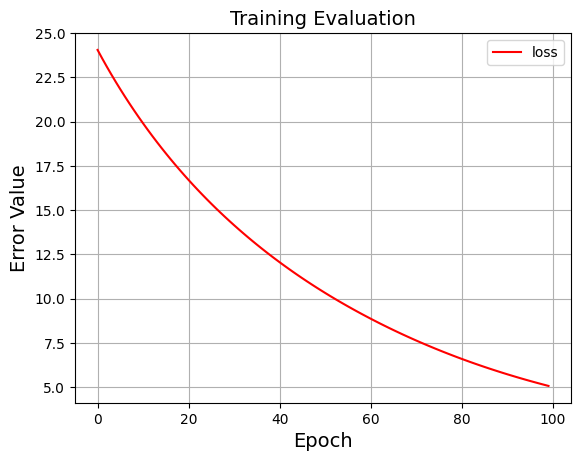

In [14]:
plt.plot(losses, label='loss', color='red')
plt.title('Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [15]:
# Create a vector of zero tensors representing 0 average per num_feature (right in the middle of the dist)
sampled_mu = torch.Tensor([np.zeros(num_features)])

# Create a vector of zero tensors representing 0 standard deviations away from the mean to create variations
# Change this is you want to sample away from the mean to create "off-quality" data
sampled_logvar = torch.Tensor([np.zeros(num_features)])

print(sampled_logvar)

sampled_logvar.shape

tensor([[0., 0., 0., 0., 0.]])


C:\Users\wmagampoadmin\AppData\Local\Temp\ipykernel_16552\563129376.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  sampled_mu = torch.Tensor([np.zeros(num_features)])


torch.Size([1, 5])

In [16]:
# Grab a reconstructed sample from the trained model
# NOTE: reconstruction returns as an array because it's possible to have multiple predictions later on
reconstruction = model.sample(sampled_mu, sampled_logvar)

In [17]:
reconstructed_data = reconstruction[0].detach().cpu().numpy()
#reconstructed_image = reconstructed_image.reshape(img_width, img_height)
#plt.imshow(reconstructed_image)
print(reconstructed_data)
print("shape: ", reconstructed_data.shape)

[0.2845399  0.37990302 0.52949935 0.4127161  0.4002585  0.4804735
 0.55987126 0.5431061  0.5068036  0.47692677]
shape:  (10,)


In [18]:
#Generate 115 sampling
reconstructed_sample = []
added_y = []

for i in range(4783):
    reconstruction = model.sample(sampled_mu, sampled_logvar)
    reconstructed_sample.append(reconstruction[0].detach().cpu().numpy())
    added_y.append([1,0])
    #print (reconstruction[0].detach().cpu().numpy())
    
    
# print(added_y)
# print(reconstructed_sample)

In [19]:
x = df_train_n1.iloc[:,:-2 ]
y = df_train_n1.iloc[:,-2: ]


columns = [0,1,2,3,4,5,6,7,8,9]
df_reconstructed_sample = pd.DataFrame(reconstructed_sample) # Making the reconstructed output as dataframe


# synching the column names for each df
df_reconstructed_sample.columns = columns 
x.columns = columns

# ==================================
# Generate fabricated data set
# ==================================
fab_x = x.append(df_reconstructed_sample, ignore_index=True) # Append x + constructed data
print(fab_x)

# 285 columns

fab_y = pd.DataFrame(added_y, columns=[-1, 1])
fab_y = y.append(fab_y, ignore_index=True)
print(fab_y)

print(fab_x.shape)
print(fab_y.shape)


              0         1         2         3         4         5         6  \
0      0.343330  0.189790  0.488941  0.153767  0.124759  0.349782  0.375302   
1      0.059677  0.060484  0.148196  0.432322  0.307157  0.451985  0.606316   
2      0.075768  0.063004  0.163217  0.454256  0.352348  0.476964  0.618876   
3      0.545450  0.647027  0.474512  0.076941  0.065936  0.191400  0.746525   
4      0.066874  0.062882  0.186753  0.525969  0.393688  0.444324  0.623307   
...         ...       ...       ...       ...       ...       ...       ...   
10766  0.311544  0.294665  0.553107  0.415643  0.298254  0.556150  0.579508   
10767  0.269481  0.389779  0.432592  0.438345  0.457148  0.522274  0.590910   
10768  0.314451  0.279441  0.627373  0.393102  0.256001  0.519632  0.547798   
10769  0.387543  0.366002  0.571610  0.404252  0.322659  0.538580  0.545052   
10770  0.360681  0.388200  0.520220  0.426258  0.380988  0.547765  0.589396   

              7         8         9  
0      0.6170

C:\Users\wmagampoadmin\AppData\Local\Temp\ipykernel_16552\2102265094.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fab_x = x.append(df_reconstructed_sample, ignore_index=True) # Append x + constructed data
C:\Users\wmagampoadmin\AppData\Local\Temp\ipykernel_16552\2102265094.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fab_y = y.append(fab_y, ignore_index=True)


### Train Neural Network using fab data

In [20]:
fab_y = torch.Tensor(fab_y.values)
fab_x = torch.Tensor(fab_x.values)


class NeuralNetwork(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.hidden_layer_1 = nn.Linear(self.in_dim, 5) # input to first hidden layer                        
        
        self.output_layer = nn.Linear(5, self.out_dim)
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        x = self.hidden_layer_1(x)
        x = self.activation(x)        
        
        y = self.output_layer(x)
        y = self.activation(y)
        
        return y

In [21]:
model = NeuralNetwork(10, 2)

# Test structure of model
predictions = model.forward(fab_x)

In [22]:
learning_rate = 0.0001

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
batch_size = 50

In [23]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class MyCustomDataset_2(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [24]:
def train_fn_2(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (data, targets) in enumerate(loop):
        predictions = model.forward(data)
        
        loss = loss_fn(predictions, targets)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

# Dataloader is in charge of:
# - partitioning data into batches
# - optionally shuffling the data
# - run the optimizer against a partition defined by this loader
custom_dataset = MyCustomDataset_2(x=fab_x, y=fab_y)

train_loader = DataLoader(
    custom_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

epochs = 100
losses = []

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn_2(
        train_loader,
        model,
        optimizer,
        loss_fn,
        batch_size
    )
    
    losses.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))
    
    state = { 'state_dict': model.state_dict() }

    torch.save(state, "magic04_model.pth")

Epoch: 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 365.96it/s, loss=0.152]


Ave Loss: 0.16358552769654328
Epoch: 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 359.47it/s, loss=0.134]


Ave Loss: 0.14521305904620224
Epoch: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 363.19it/s, loss=0.118]


Ave Loss: 0.1281293442265855
Epoch: 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 377.18it/s, loss=0.103]


Ave Loss: 0.1124494896373815
Epoch: 4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 364.37it/s, loss=0.0893]


Ave Loss: 0.09826381901210104
Epoch: 5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 377.81it/s, loss=0.0773]


Ave Loss: 0.08558687574609562
Epoch: 6


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 348.24it/s, loss=0.0669]


Ave Loss: 0.074366325478035
Epoch: 7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 293.72it/s, loss=0.0577]


Ave Loss: 0.06450711426980517
Epoch: 8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 342.65it/s, loss=0.0498]


Ave Loss: 0.05589595985495382
Epoch: 9


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 335.79it/s, loss=0.0429]


Ave Loss: 0.048416026057330544
Epoch: 10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 370.42it/s, loss=0.0371]


Ave Loss: 0.04195074859523663
Epoch: 11


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 368.32it/s, loss=0.032]


Ave Loss: 0.0363844831439632
Epoch: 12


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 362.27it/s, loss=0.0277]


Ave Loss: 0.03160469936793325
Epoch: 13


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 338.00it/s, loss=0.0241]


Ave Loss: 0.027505317909850016
Epoch: 14


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 321.63it/s, loss=0.021]


Ave Loss: 0.023989577717320236
Epoch: 15


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 359.54it/s, loss=0.0183]


Ave Loss: 0.0209715753638496
Epoch: 16


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 342.37it/s, loss=0.016]


Ave Loss: 0.018376586260274053
Epoch: 17


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 370.74it/s, loss=0.014]


Ave Loss: 0.01614054345042893
Epoch: 18


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 369.85it/s, loss=0.0123]


Ave Loss: 0.014209048343925841
Epoch: 19


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 367.07it/s, loss=0.0109]


Ave Loss: 0.012536211650715105
Epoch: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 404.49it/s, loss=0.00959]


Ave Loss: 0.011083453397818462
Epoch: 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 408.81it/s, loss=0.00849]


Ave Loss: 0.009818364008053861
Epoch: 22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 411.30it/s, loss=0.00753]


Ave Loss: 0.008713760846553164
Epoch: 23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 399.83it/s, loss=0.00669]


Ave Loss: 0.007746776203728384
Epoch: 24


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 362.54it/s, loss=0.00595]


Ave Loss: 0.006898162101774856
Epoch: 25


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 296.18it/s, loss=0.0053]


Ave Loss: 0.006151665545379122
Epoch: 26


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 298.19it/s, loss=0.00473]


Ave Loss: 0.005493533918289123
Epoch: 27


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 350.88it/s, loss=0.00423]


Ave Loss: 0.004912091845956941
Epoch: 28


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 312.06it/s, loss=0.00378]


Ave Loss: 0.004397384117409173
Epoch: 29


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 268.73it/s, loss=0.00339]


Ave Loss: 0.003940914823302861
Epoch: 30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 307.78it/s, loss=0.00304]


Ave Loss: 0.003535407968296635
Epoch: 31


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 291.50it/s, loss=0.00273]


Ave Loss: 0.0031745943717261843
Epoch: 32


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 331.83it/s, loss=0.00245]


Ave Loss: 0.002853068526342718
Epoch: 33


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 377.79it/s, loss=0.0022]


Ave Loss: 0.0025661593967082875
Epoch: 34


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 369.65it/s, loss=0.00198]


Ave Loss: 0.0023098134120960756
Epoch: 35


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 383.42it/s, loss=0.00179]


Ave Loss: 0.002080499827301268
Epoch: 36


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 394.41it/s, loss=0.00161]


Ave Loss: 0.001875143768740128
Epoch: 37


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 386.95it/s, loss=0.00145]


Ave Loss: 0.0016910528755505329
Epoch: 38


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 381.03it/s, loss=0.00131]


Ave Loss: 0.0015258681130405792
Epoch: 39


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 379.45it/s, loss=0.00118]


Ave Loss: 0.0013775183841870683
Epoch: 40


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 385.63it/s, loss=0.00107]


Ave Loss: 0.0012441779701341013
Epoch: 41


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 372.73it/s, loss=0.000966]


Ave Loss: 0.0011242383110651713
Epoch: 42


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 383.08it/s, loss=0.000873]


Ave Loss: 0.0010162751436669
Epoch: 43


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 388.09it/s, loss=0.00079]


Ave Loss: 0.0009190278093835028
Epoch: 44


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 363.97it/s, loss=0.000715]


Ave Loss: 0.0008313804708585074
Epoch: 45


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 385.08it/s, loss=0.000647]


Ave Loss: 0.0007523401582147926
Epoch: 46


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 396.36it/s, loss=0.000586]


Ave Loss: 0.000681024523617924
Epoch: 47


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 374.26it/s, loss=0.00053]


Ave Loss: 0.0006166471187801411
Epoch: 48


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 360.43it/s, loss=0.000481]


Ave Loss: 0.0005585049695111122
Epoch: 49


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 347.92it/s, loss=0.000435]


Ave Loss: 0.0005059728650343863
Epoch: 50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 344.27it/s, loss=0.000395]


Ave Loss: 0.00045848940458704927
Epoch: 51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 381.84it/s, loss=0.000358]


Ave Loss: 0.0004155542033172592
Epoch: 52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 375.53it/s, loss=0.000325]


Ave Loss: 0.0003767176352051104
Epoch: 53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 348.97it/s, loss=0.000294]


Ave Loss: 0.00034157733723447935
Epoch: 54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 345.69it/s, loss=0.000267]


Ave Loss: 0.0003097715559340065
Epoch: 55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 341.75it/s, loss=0.000242]


Ave Loss: 0.00028097599776325904
Epoch: 56


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 371.87it/s, loss=0.00022]


Ave Loss: 0.00025489790284525415
Epoch: 57


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 378.24it/s, loss=0.0002]


Ave Loss: 0.00023127551712268205
Epoch: 58


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 392.73it/s, loss=0.000181]


Ave Loss: 0.00020987280347779032
Epoch: 59


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 377.77it/s, loss=0.000165]


Ave Loss: 0.00019047593997567201
Epoch: 60


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 375.11it/s, loss=0.000149]


Ave Loss: 0.00017289420759846475
Epoch: 61


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 380.50it/s, loss=0.000136]


Ave Loss: 0.00015695442642835487
Epoch: 62


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 377.25it/s, loss=0.000123]


Ave Loss: 0.00014249972506756117
Epoch: 63


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 331.67it/s, loss=0.000112]


Ave Loss: 0.00012939034382321147
Epoch: 64


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 363.25it/s, loss=0.000102]


Ave Loss: 0.00011749908976020783
Epoch: 65


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 385.40it/s, loss=9.25e-5]


Ave Loss: 0.00010671090485966825
Epoch: 66


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 391.84it/s, loss=8.4e-5]


Ave Loss: 9.692223173058462e-05
Epoch: 67


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 379.86it/s, loss=7.64e-5]


Ave Loss: 8.803913745699295e-05
Epoch: 68


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 395.41it/s, loss=6.94e-5]


Ave Loss: 7.997678986376505e-05
Epoch: 69


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 387.52it/s, loss=6.31e-5]


Ave Loss: 7.265860201894409e-05
Epoch: 70


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 391.00it/s, loss=5.74e-5]


Ave Loss: 6.601491595911621e-05
Epoch: 71


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 394.39it/s, loss=5.22e-5]


Ave Loss: 5.998276494075846e-05
Epoch: 72


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 389.60it/s, loss=4.74e-5]


Ave Loss: 5.4505613021589214e-05
Epoch: 73


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 389.47it/s, loss=4.31e-5]


Ave Loss: 4.9531781348411675e-05
Epoch: 74


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 389.63it/s, loss=3.92e-5]


Ave Loss: 4.5014389275753206e-05
Epoch: 75


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 387.38it/s, loss=3.57e-5]


Ave Loss: 4.0911458216686256e-05
Epoch: 76


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 360.65it/s, loss=3.24e-5]


Ave Loss: 3.71845739950745e-05
Epoch: 77


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 379.60it/s, loss=2.95e-5]


Ave Loss: 3.379901080633216e-05
Epoch: 78


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 383.98it/s, loss=2.68e-5]


Ave Loss: 3.072324187558951e-05
Epoch: 79


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 378.14it/s, loss=2.44e-5]


Ave Loss: 2.7928739032008537e-05
Epoch: 80


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 365.37it/s, loss=2.22e-5]


Ave Loss: 2.5389585685102417e-05
Epoch: 81


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 373.48it/s, loss=2.02e-5]


Ave Loss: 2.3082302664921304e-05
Epoch: 82


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 386.81it/s, loss=1.84e-5]


Ave Loss: 2.098558977397463e-05
Epoch: 83


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 380.94it/s, loss=1.67e-5]


Ave Loss: 1.90801266836826e-05
Epoch: 84


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 392.11it/s, loss=1.52e-5]


Ave Loss: 1.7348348150234313e-05
Epoch: 85


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 395.64it/s, loss=1.38e-5]


Ave Loss: 1.5774392291287194e-05
Epoch: 86


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 377.16it/s, loss=1.26e-5]


Ave Loss: 1.43437880945351e-05
Epoch: 87


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 380.46it/s, loss=1.14e-5]


Ave Loss: 1.3043393041530012e-05
Epoch: 88


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 368.29it/s, loss=1.04e-5]


Ave Loss: 1.1861266721603493e-05
Epoch: 89


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 373.00it/s, loss=9.48e-6]


Ave Loss: 1.0786654473593916e-05
Epoch: 90


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 382.20it/s, loss=8.63e-6]


Ave Loss: 9.809712558442832e-06
Epoch: 91


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 378.68it/s, loss=7.85e-6]


Ave Loss: 8.921505877036975e-06
Epoch: 92


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 351.96it/s, loss=7.14e-6]


Ave Loss: 8.113989742418602e-06
Epoch: 93


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 378.60it/s, loss=6.5e-6]


Ave Loss: 7.379788914679213e-06
Epoch: 94


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 383.92it/s, loss=5.92e-6]


Ave Loss: 6.712228925893955e-06
Epoch: 95


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 390.19it/s, loss=5.38e-6]


Ave Loss: 6.105240446332674e-06
Epoch: 96


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 389.25it/s, loss=4.9e-6]


Ave Loss: 5.553301382069212e-06
Epoch: 97


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 388.55it/s, loss=4.46e-6]


Ave Loss: 5.051380574732994e-06
Epoch: 98


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 383.57it/s, loss=4.06e-6]


Ave Loss: 4.594953477660763e-06
Epoch: 99


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 378.21it/s, loss=3.7e-6]

Ave Loss: 4.179897306105178e-06


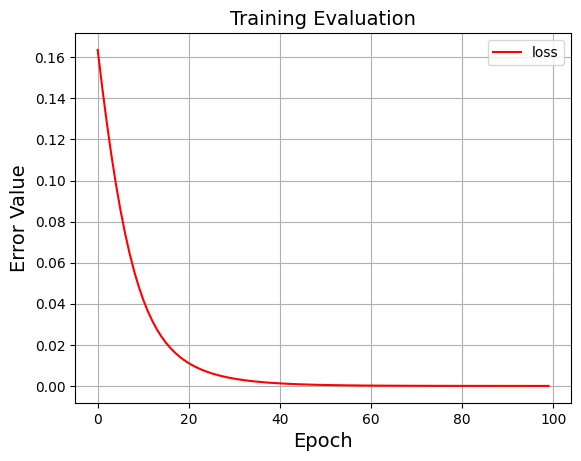

In [25]:
plt.plot(losses, label='loss', color='red')
plt.title('Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [26]:
y_test = pd.get_dummies(y_test)
# y_test = torch.Tensor(y_test.values)
x_test = torch.Tensor(x_test.values)

model = NeuralNetwork(10, 2)

predictions = model.forward(x_test)
preds = predictions.detach().cpu().numpy()

ohe = []
for i in preds:
       if i[0] > i[1]:
         ohe.append([1,0])
       else:
        ohe.append([0,1])
#preds
ohe

acc = accuracy_score(ohe, y_test)
cl_report = classification_report(ohe, y_test)
print("acc: ", acc)
print("cl report: ", cl_report)

acc:  0.6553945249597424
cl report:                precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.66      0.79      1863

   micro avg       0.66      0.66      0.66      1863
   macro avg       0.50      0.33      0.40      1863
weighted avg       1.00      0.66      0.79      1863
 samples avg       0.66      0.66      0.66      1863



D:\Data Engineering Class\NeuralNetwork_contest\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
